In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Autoencoders
An autoencoder is a network which is used to encode and decode data. It is an example of unsupervised learning. In this notebook, we will train an autoencoder for compressing data. The goal is to reduce the difference between original input and the output of the autoencoder

In [4]:
cd '/content/drive/My Drive/task_GSoC/Autoencoder/HEPAutoencoders/4D'

/content/drive/My Drive/task_GSoC/Autoencoder/HEPAutoencoders/4D


Import libraries

In [0]:

%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


For training your own network, define it in the file nn_utils and import it here. In this notebook, I will be using the network *AE_3D_minahil*

In [0]:
from nn_utils import AE_3D_minahil
from utils import plot_activations

In [7]:
if torch.cuda.is_available():
  fastai.torch_core.defaults.device = 'cuda'
fastai.torch_core.defaults.device

'cuda'

###Train and Test Dataset

In [8]:
# Load data
train = pd.read_pickle(BIN + '../GSOC_Evaluation_Datasets/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle(BIN + '../GSOC_Evaluation_Datasets/all_jets_test_4D_100_percent.pkl')

print("Number of examples in the training dataset = "+str(train.shape[0]))
print("Number of features/variables in each example = "+str(train.shape[1])+"\n")
train.head(5)

Number of examples in the training dataset = 111778
Number of features/variables in each example = 4



,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [9]:
print("\nNumber of examples in the testing dataset = "+str(test.shape[0]))
print("Number of features/variables in each example = "+str(test.shape[1]))
test.head(5)


Number of examples in the testing dataset = 27945
Number of features/variables in each example = 4


,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


In [0]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

###Dataloader

A dataloader is an object which loads minibatched every epoch

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [0]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [14]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fb65a828a20>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fb65ac2c7b8>;

Test: None

###Model definition

The description of the model is printed in the cell below.

In [15]:
model = AE_3D_minahil().double()
model.describe()

'in-64-128-256-100-50-24-3-24-50-100-256-128-64-out'

###Loss function
For this training, we will be using the mean squared error loss. The loss function for autoencoders is also called reconstruction loss.

In [0]:
loss_func = nn.MSELoss()

###Learning Rate
lr_finder helps in finding an initial learning rate for our problem. After starting with a good learning rate, we can decay it as we proceed with training

In [0]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [18]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


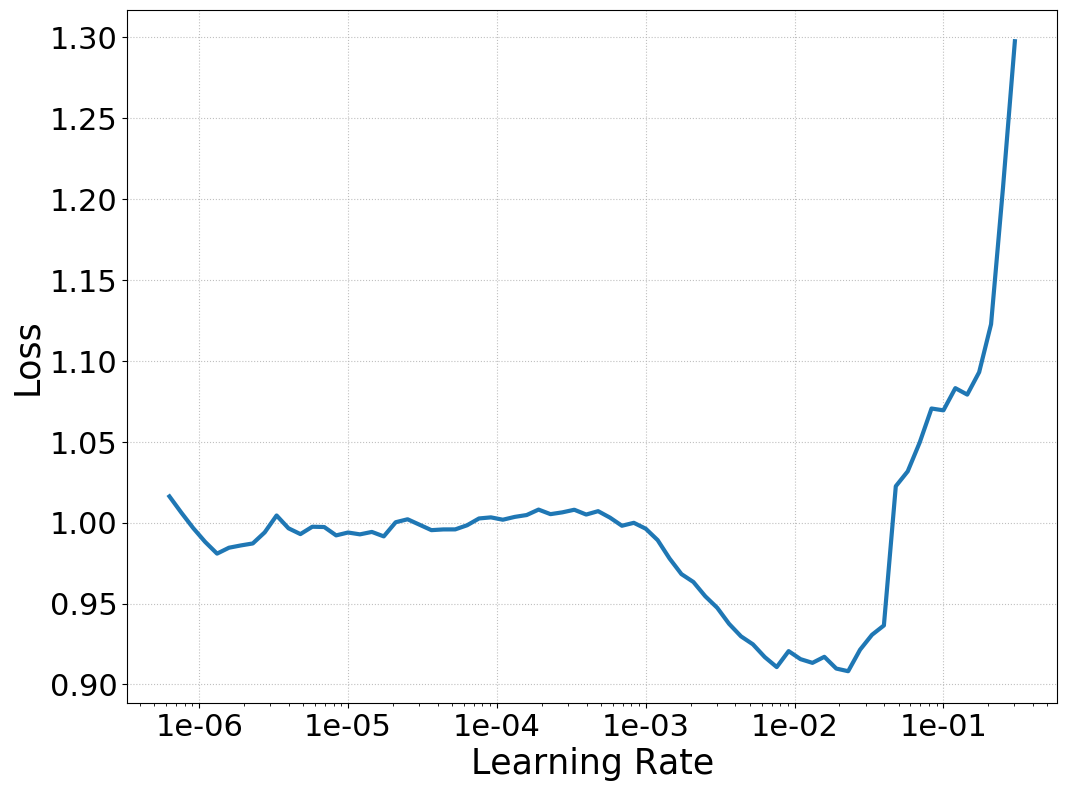

In [19]:
learn.recorder.plot()

##Training

I started with a learning rate of 0.001 and decayed it after several epochs. The train and validation losses have also been plotted.

In [20]:
lr = 1e-3
learn.fit(200, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.038056,0.039361,00:05
1,0.031643,0.033307,00:05
2,0.028787,0.033527,00:05
3,0.029389,0.029017,00:05
4,0.026838,0.027863,00:05
5,0.025435,0.025515,00:05
6,0.023386,0.024523,00:05
7,0.019980,0.021747,00:05
8,0.018905,0.020730,00:05
9,0.019795,0.023422,00:05


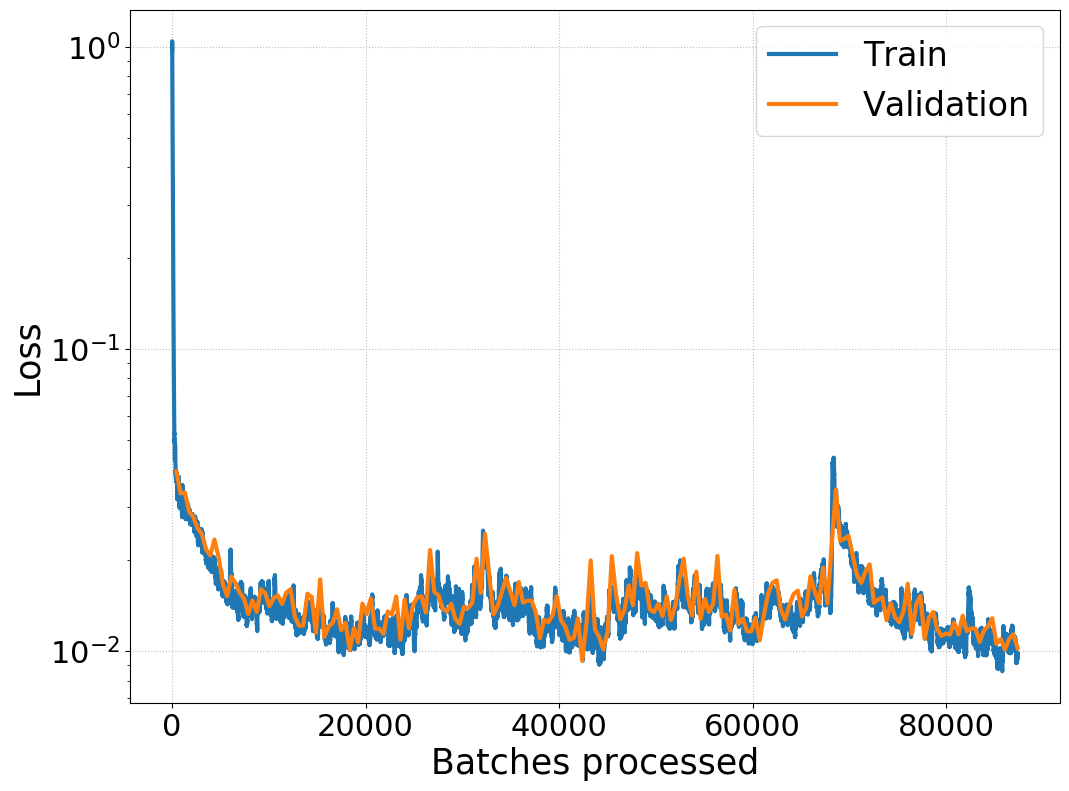

In [21]:
learn.recorder.plot_losses()
plt.yscale('log')

In [22]:
lr = 5e-4
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.007964,0.008230,00:05
1,0.007678,0.008389,00:05
2,0.007746,0.008379,00:05
3,0.007952,0.007962,00:05
4,0.008293,0.008191,00:05
5,0.008883,0.009150,00:05
6,0.008568,0.008623,00:05
7,0.009096,0.009706,00:05
8,0.008756,0.008938,00:05
9,0.008806,0.009152,00:05


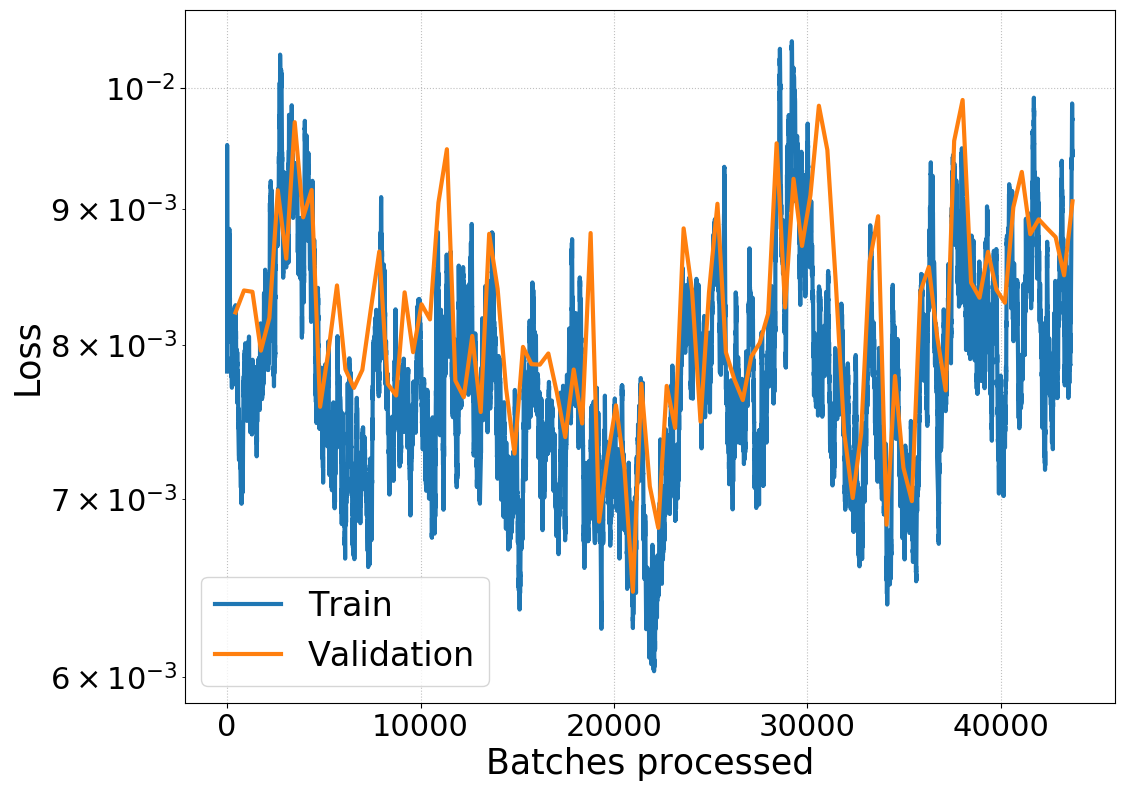

In [23]:
learn.recorder.plot_losses()
plt.yscale('log')

In [24]:
lr = 1e-4
learn.fit(30, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.008154,0.008326,00:05
1,0.008107,0.008760,00:05
2,0.007588,0.008379,00:05
3,0.007418,0.007943,00:05
4,0.007689,0.007886,00:05
5,0.006731,0.007449,00:05
6,0.007350,0.007636,00:05
7,0.006603,0.007468,00:05
8,0.007177,0.007590,00:05
9,0.006840,0.007346,00:05


In [0]:
learn.save('AE_3D_minahil')

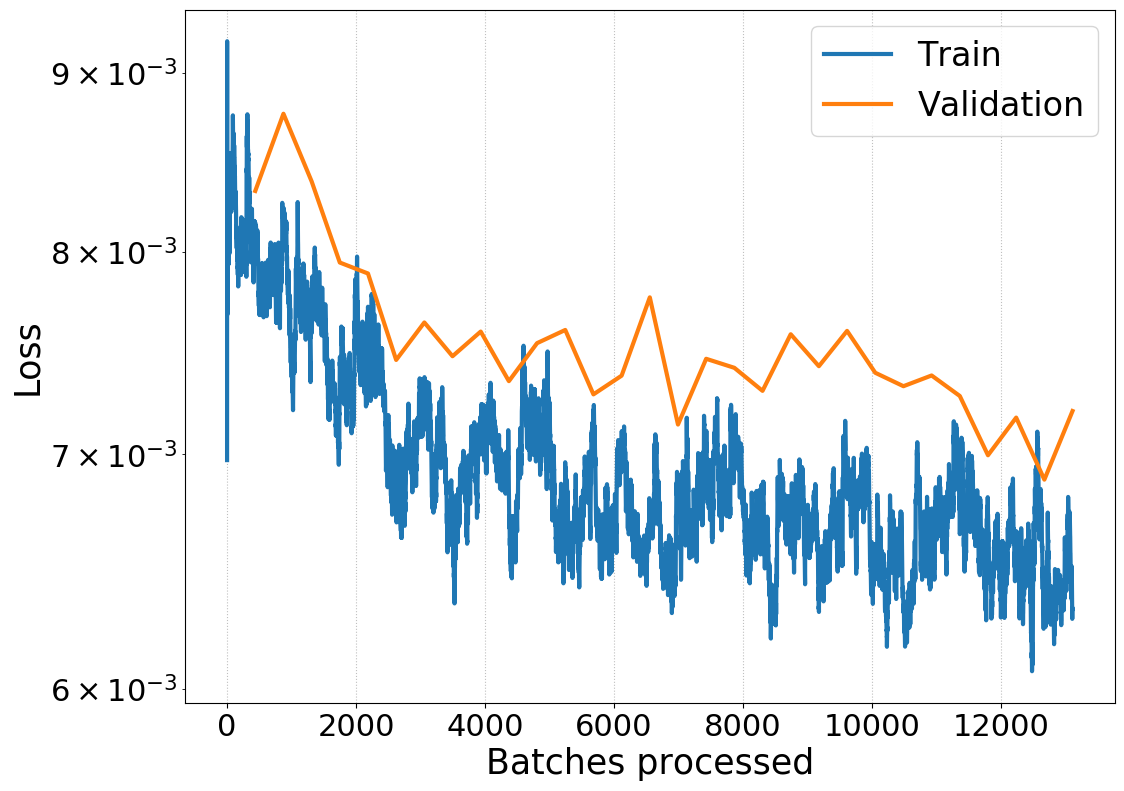

In [26]:
learn.recorder.plot_losses()
plt.yscale('log')

In [27]:
lr = 5e-5
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.006368,0.006831,00:05
1,0.006181,0.006842,00:05
2,0.006435,0.006888,00:05
3,0.006694,0.006934,00:05
4,0.006333,0.006849,00:05
5,0.005830,0.006892,00:05
6,0.006259,0.007007,00:05
7,0.006049,0.006870,00:05
8,0.006466,0.006679,00:05
9,0.006156,0.006640,00:05


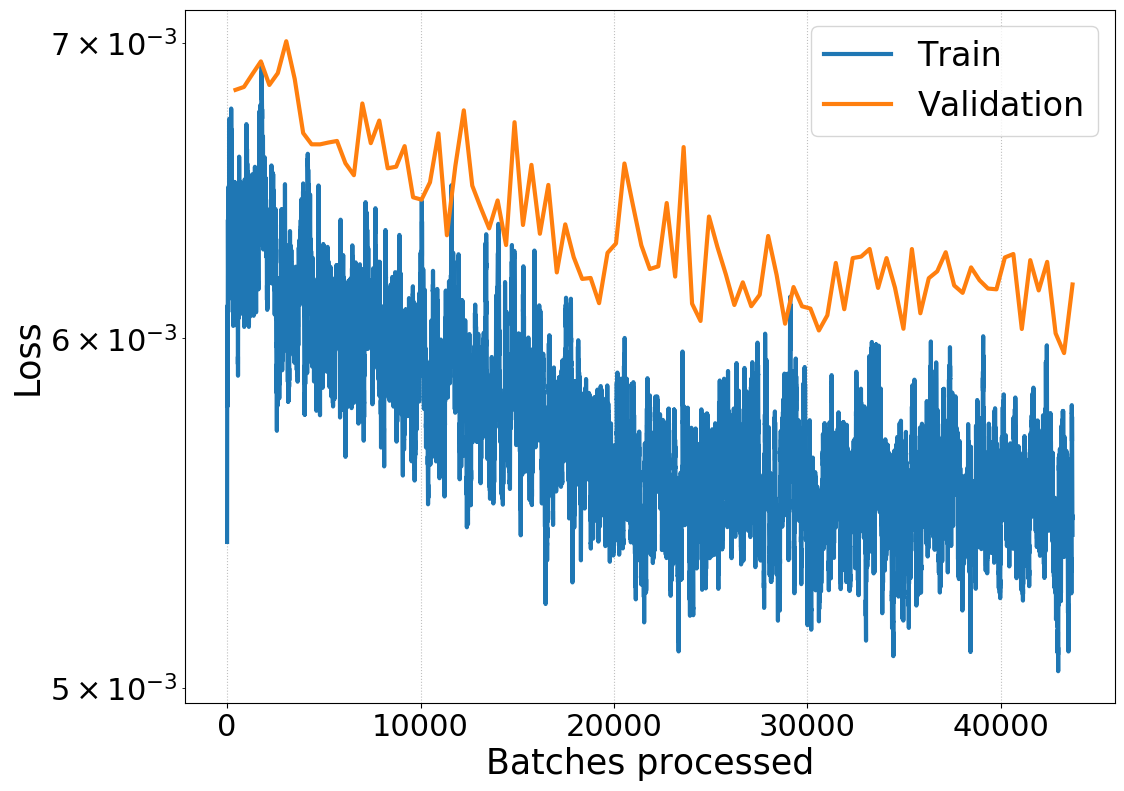

In [28]:
learn.recorder.plot_losses()
plt.yscale('log')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


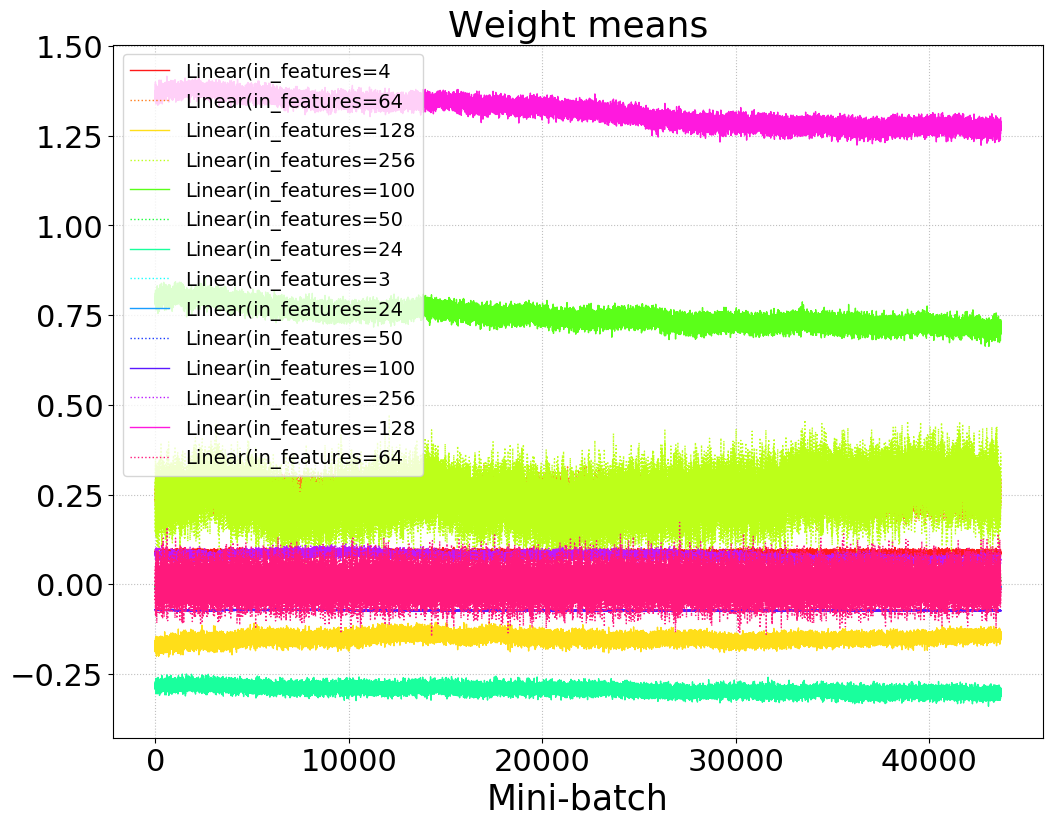

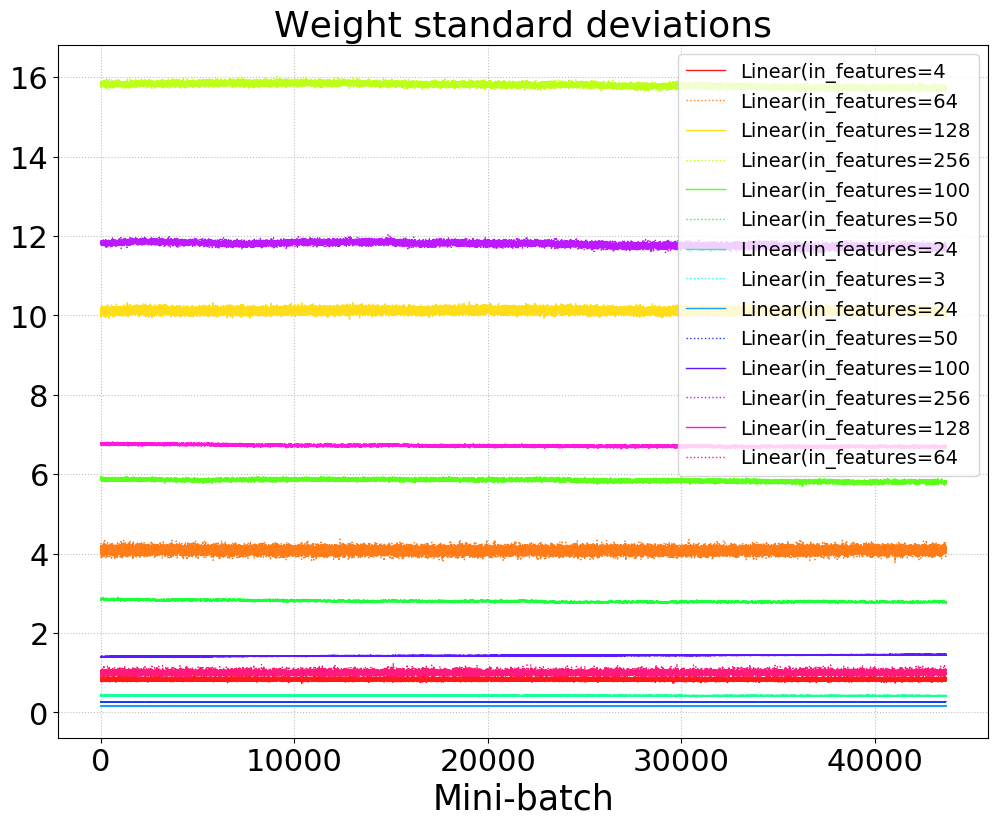

In [29]:
plot_activations(learn)

####Save Model

In [0]:

learn.save("Minahil_1")

#Evaluation
In this part of the notevook, we will evaluate the performance of the trained model on test data. For this purpose, we will consider the following metrics/methods:
1. Visualization of input and output on the same graph
2. Residuals (plots of the difference between original and uncompressed variables for each entry of the dataset, divided by the original variable)
3. Reconstruction loss
4. Correlation



---

###Visualization of input and output on the same graph

Plotting input over output helps in observing the differences and similarities between the distribution of these two. The more they overlap the better.


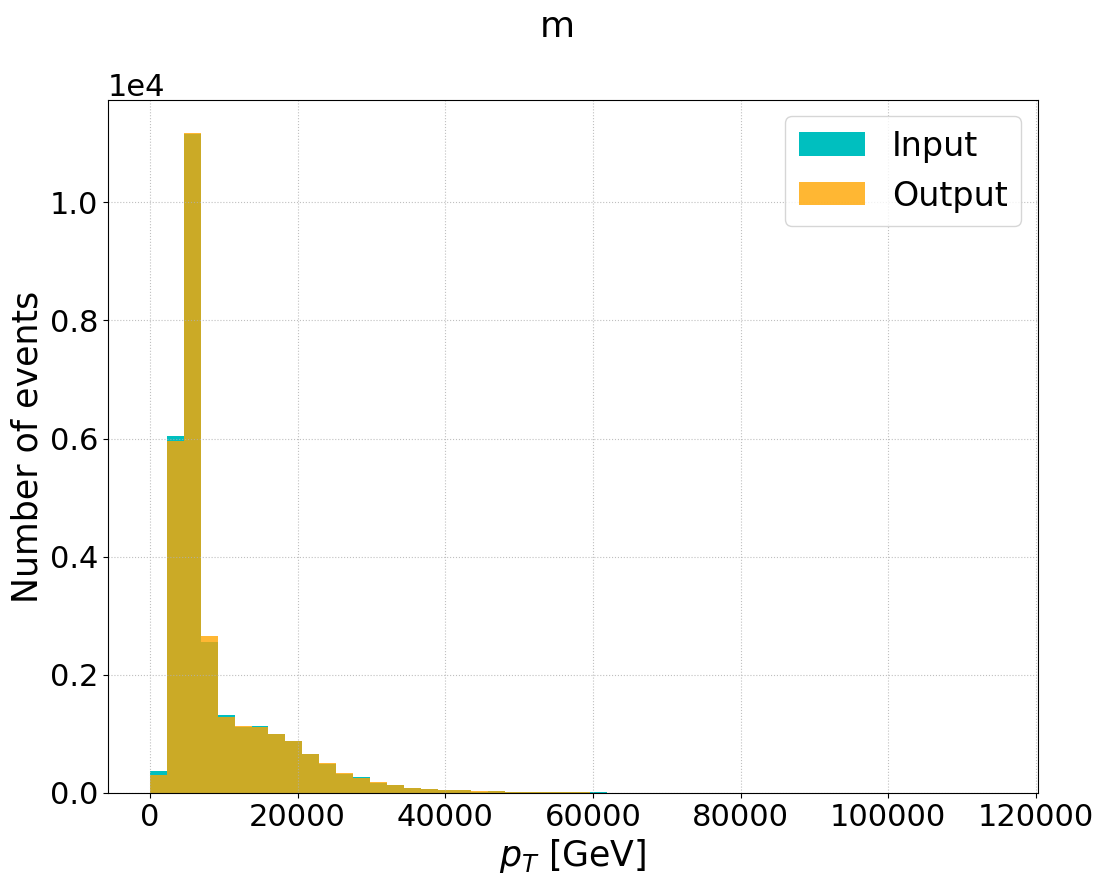

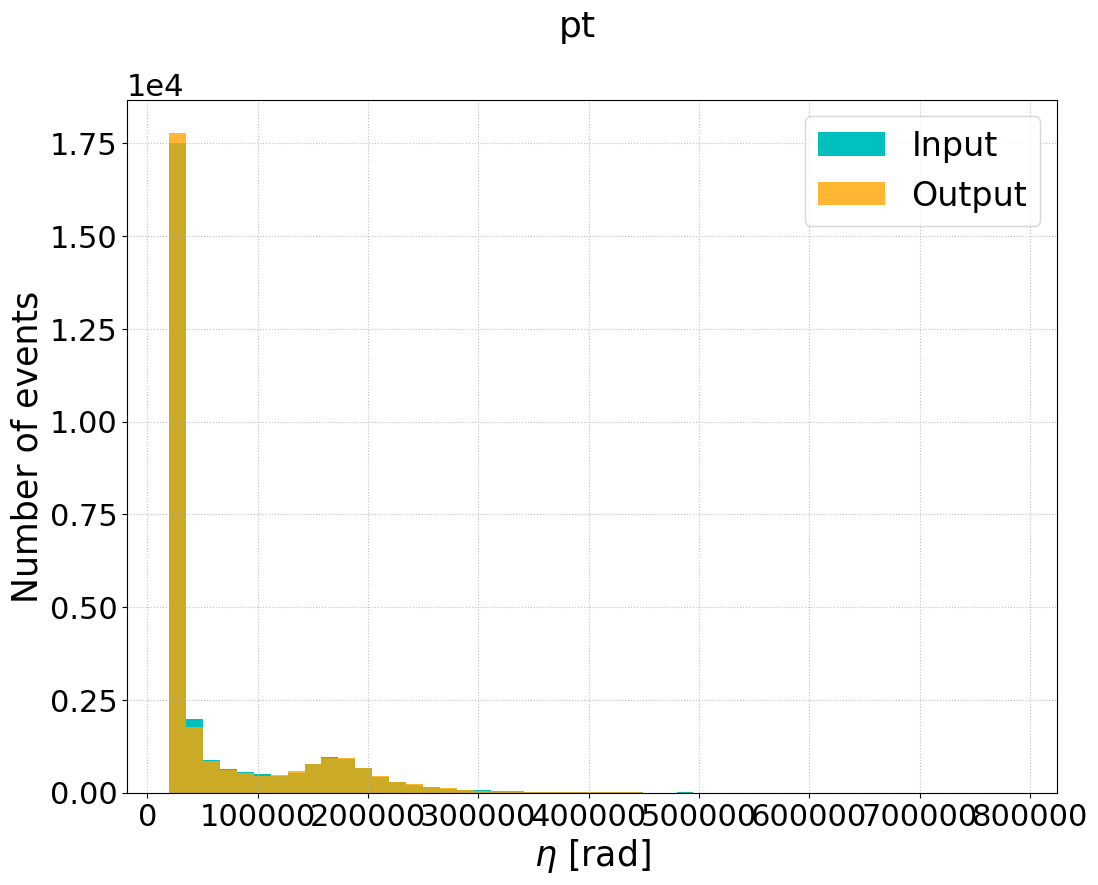

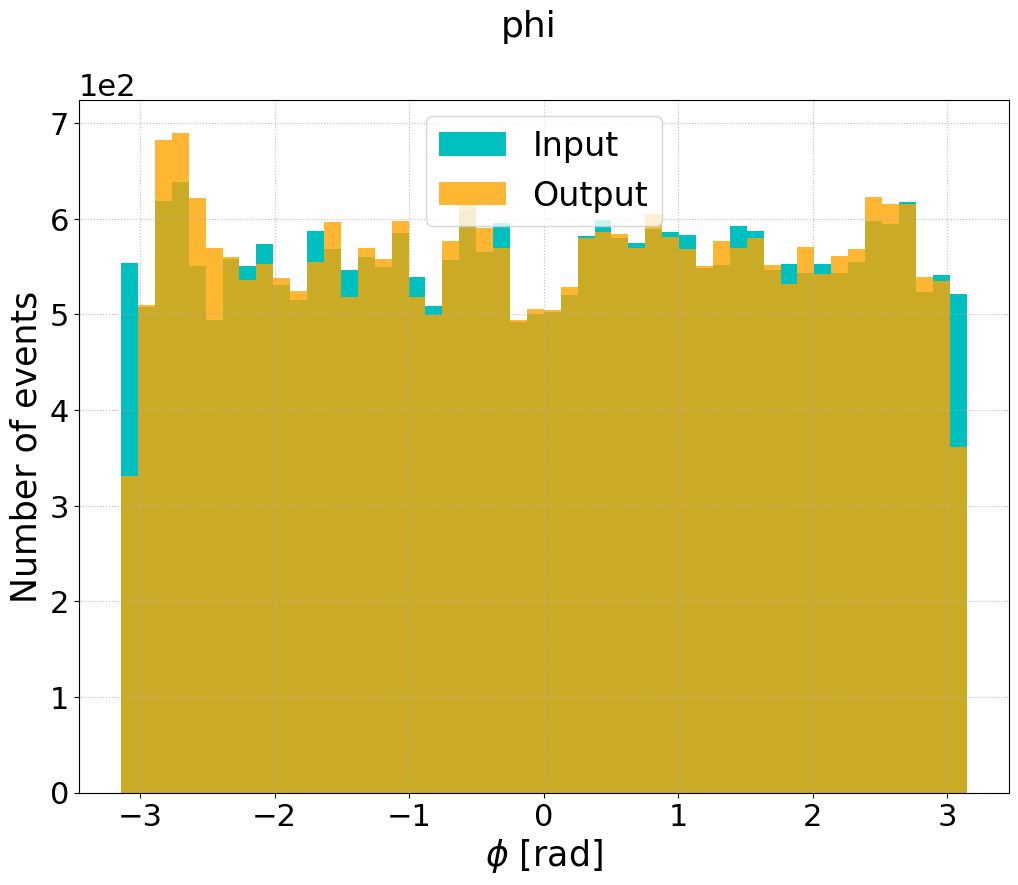

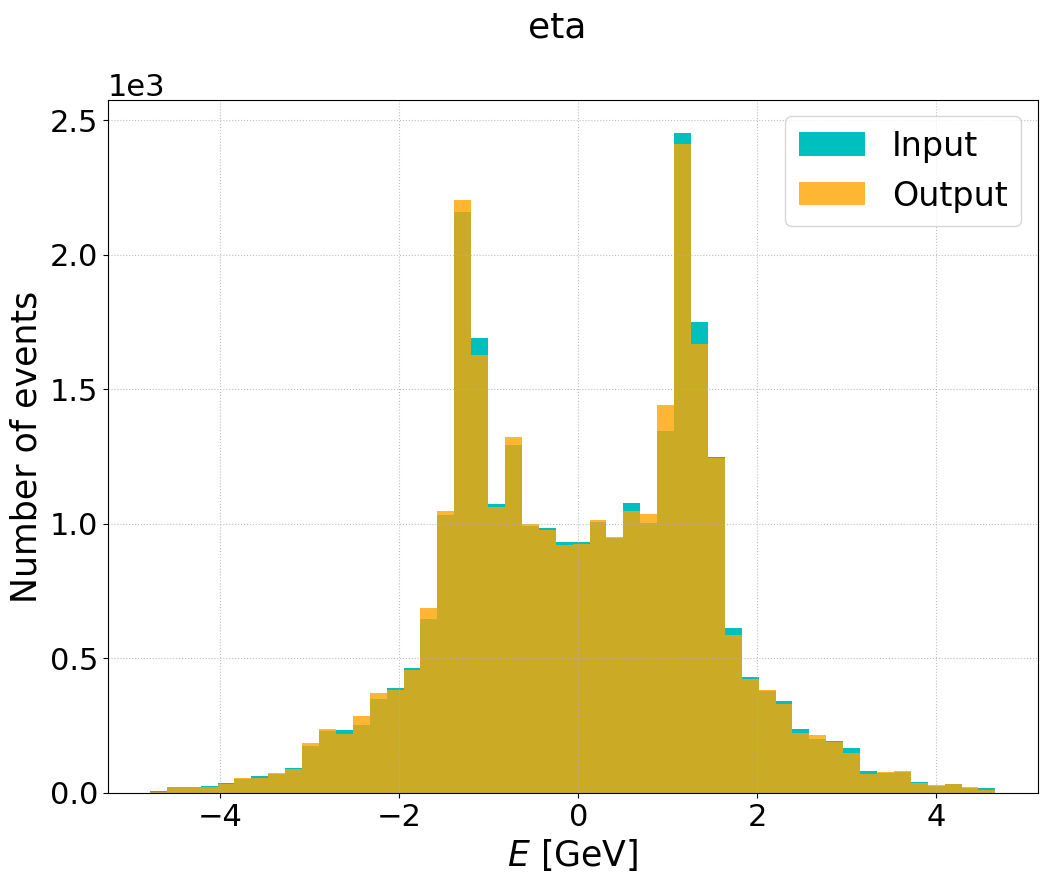

In [30]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

###Residuals 
REsiduals are plots of the difference between original and uncompressed variables for each entry of the dataset, divided by the original variable. They help in undetsyanding the percentage error in reconstruction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


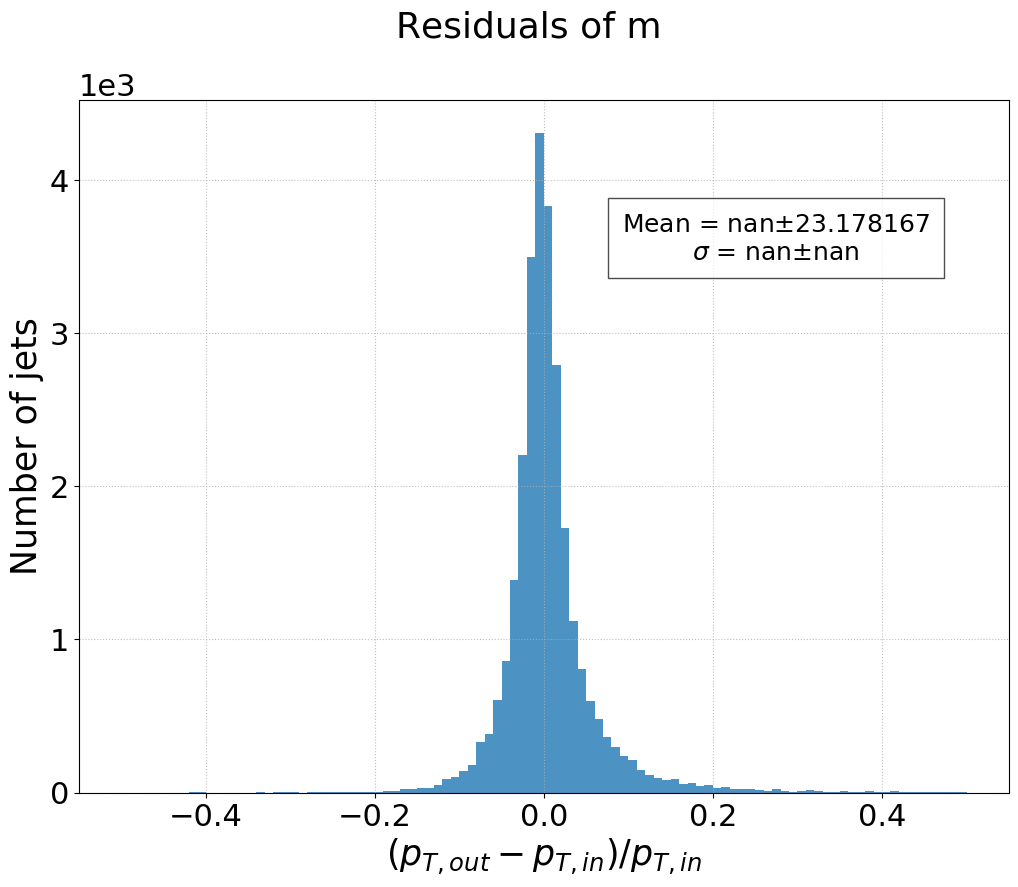

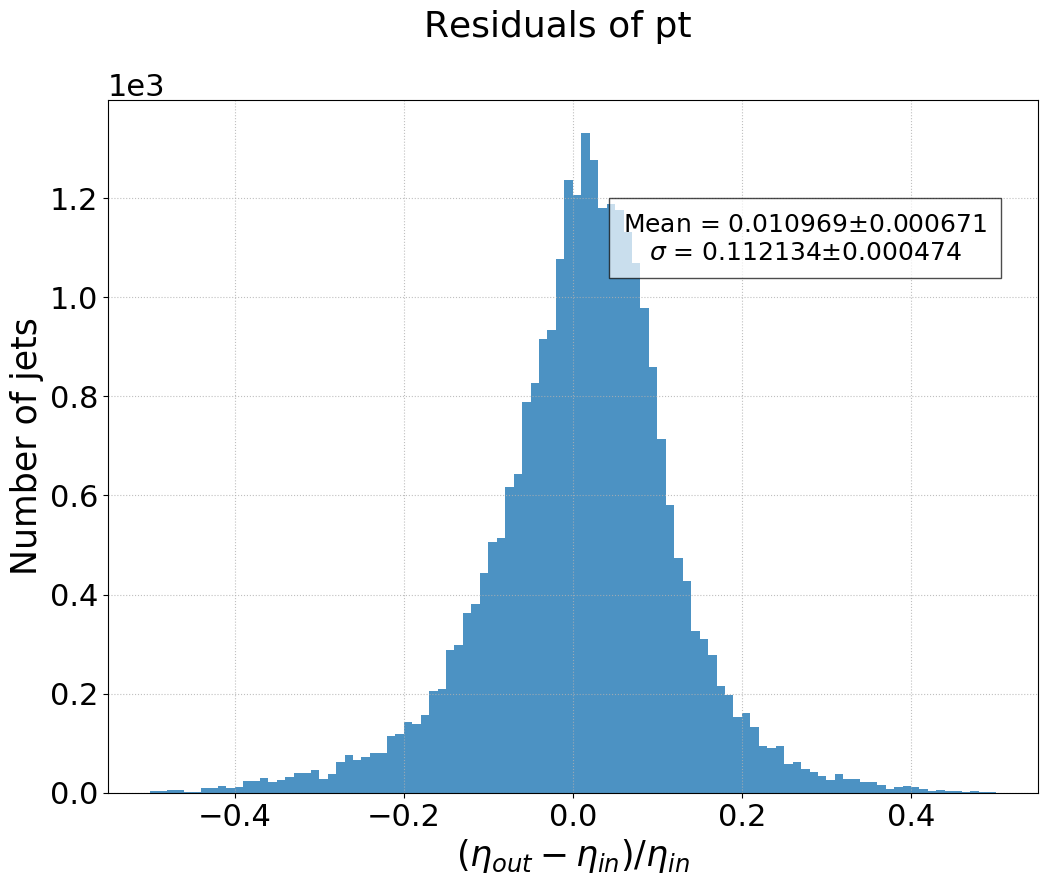

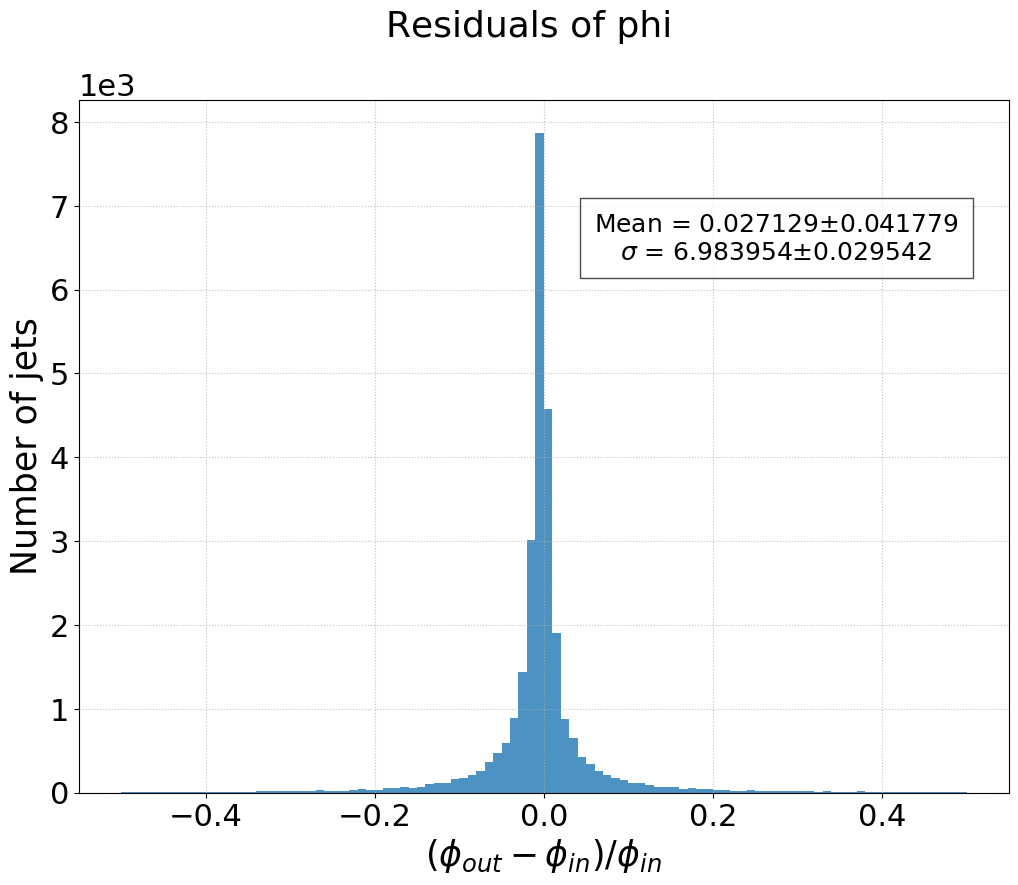

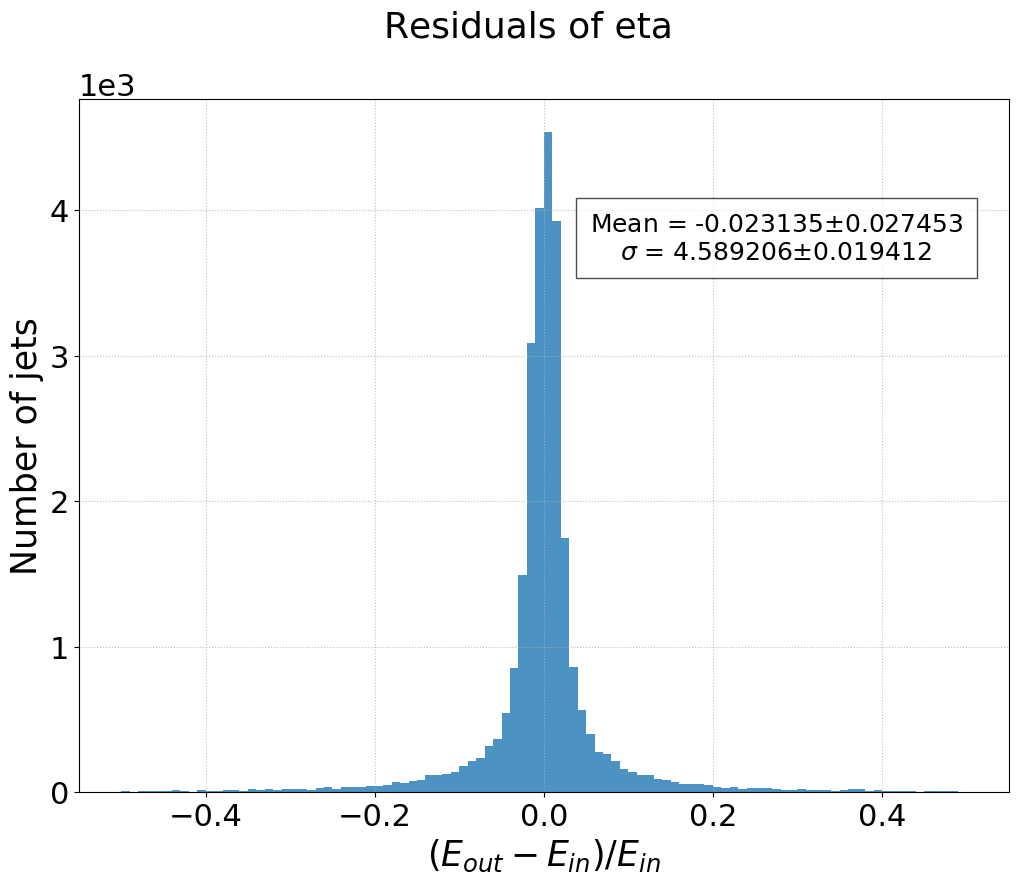

In [31]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-0.5, 0.5)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

###Reconstruction Loss

The reconstruction loss is a measure of how much data is lost during reconstruction. We will consider the following losses here.
1. Mean Squared Error
2. Absolute difference


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


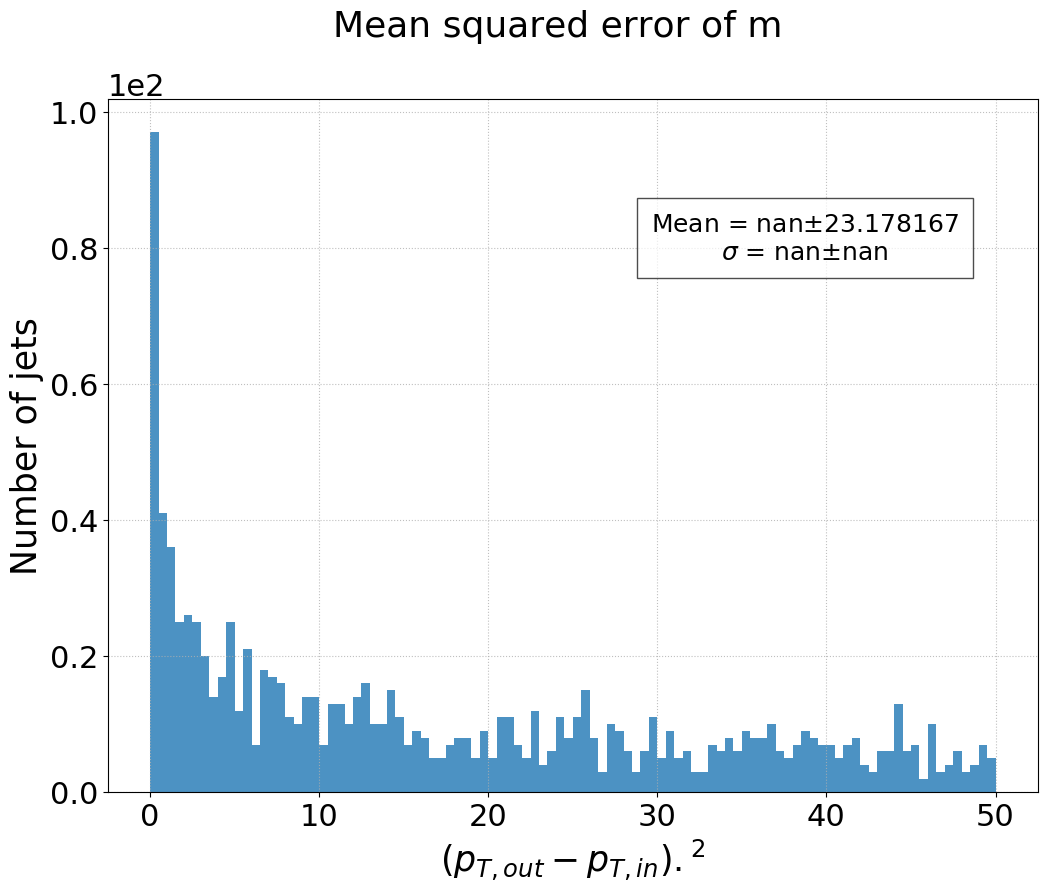

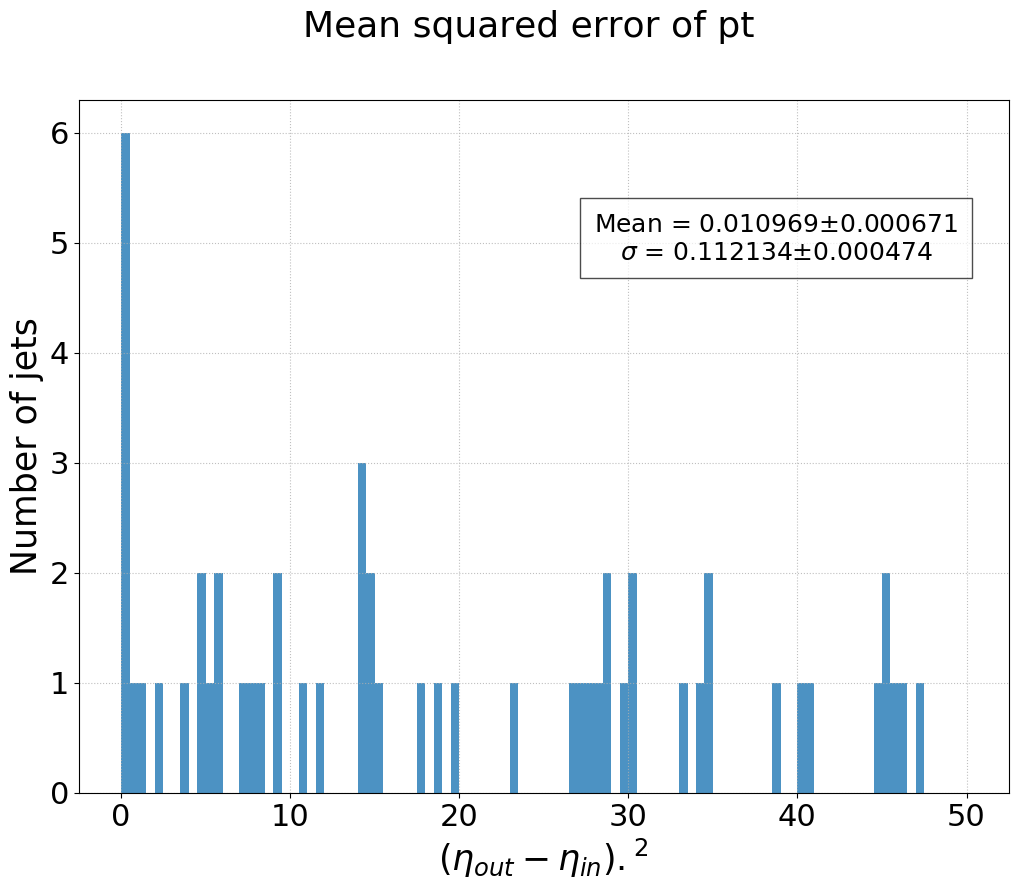

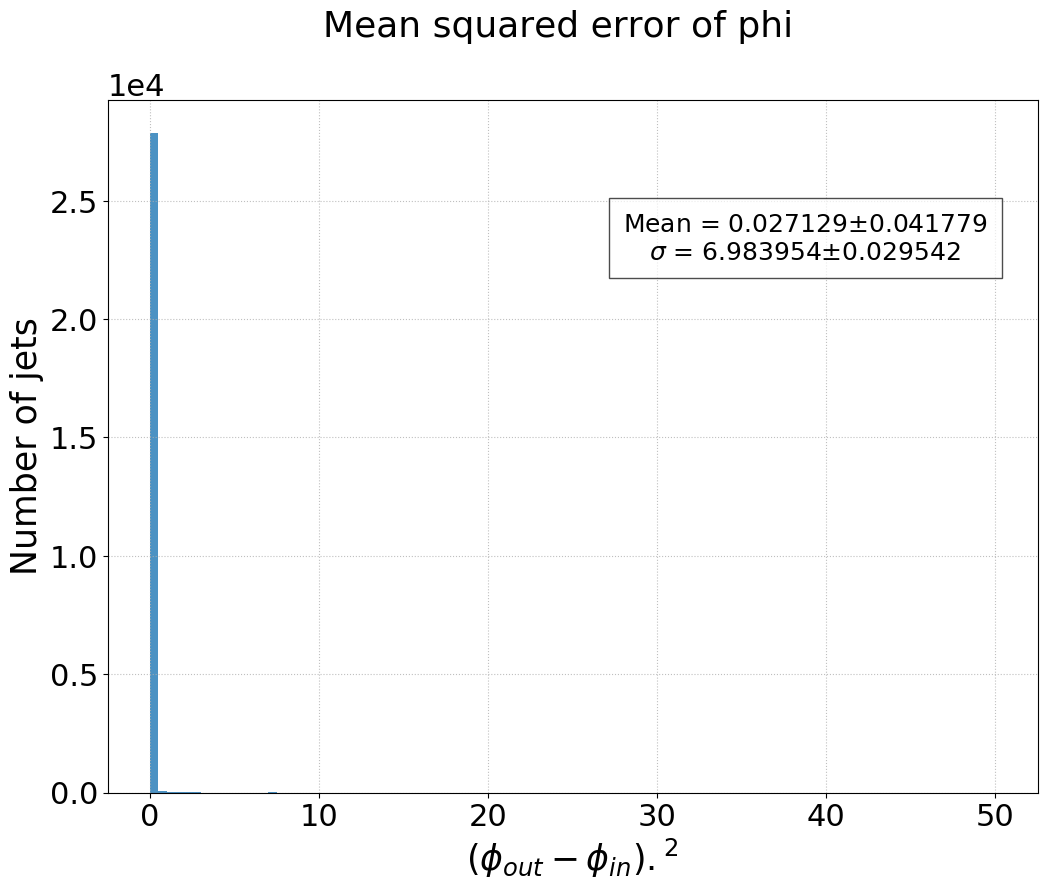

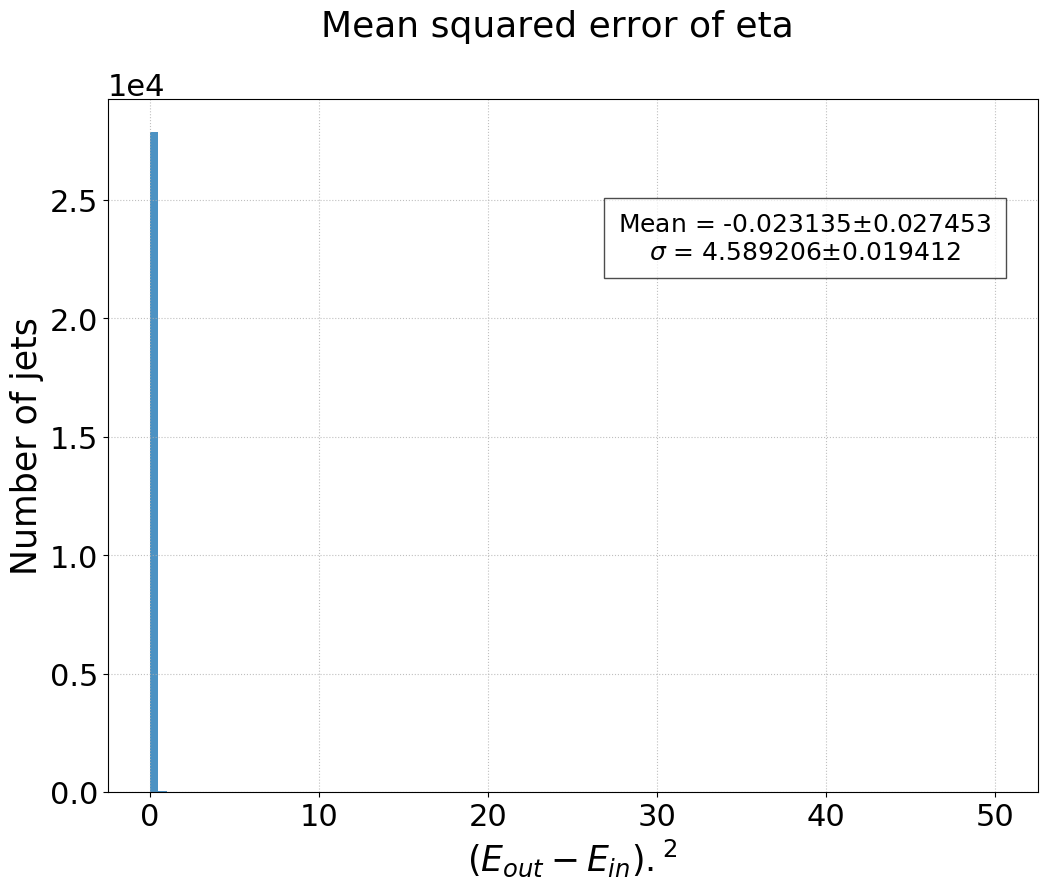

In [32]:
mse_strings = [r'$(p_{T,out} - p_{T,in}) .^2$',
                        r'$(\eta_{out} - \eta_{in}) .^2$',
                        r'$(\phi_{out} - \phi_{in}) .^2$',
                        r'$(E_{out} - E_{in}) .^2$']
mse = np.square(pred - data.detach().numpy()) 
range = (-0, 50)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        mse[:, kk], label='Mean Squared Error', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Mean squared error of %s' % train.columns[kk])
    plt.xlabel(mse_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_mse_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)



/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


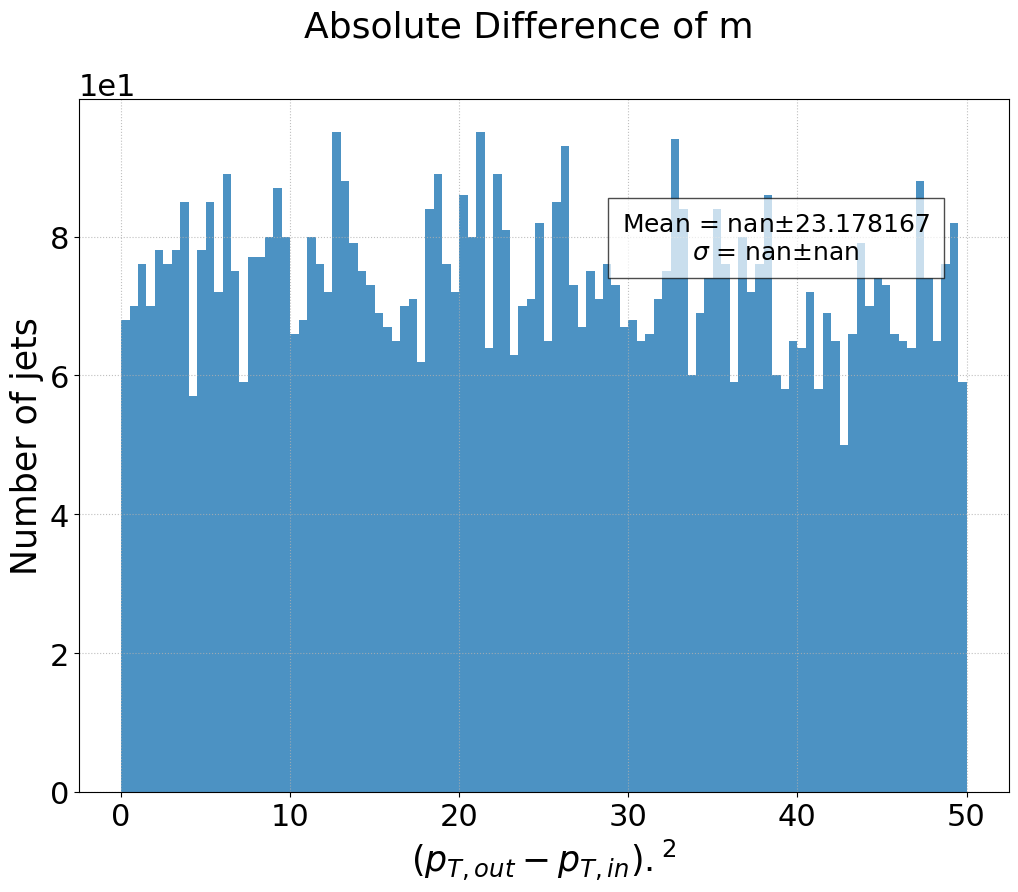

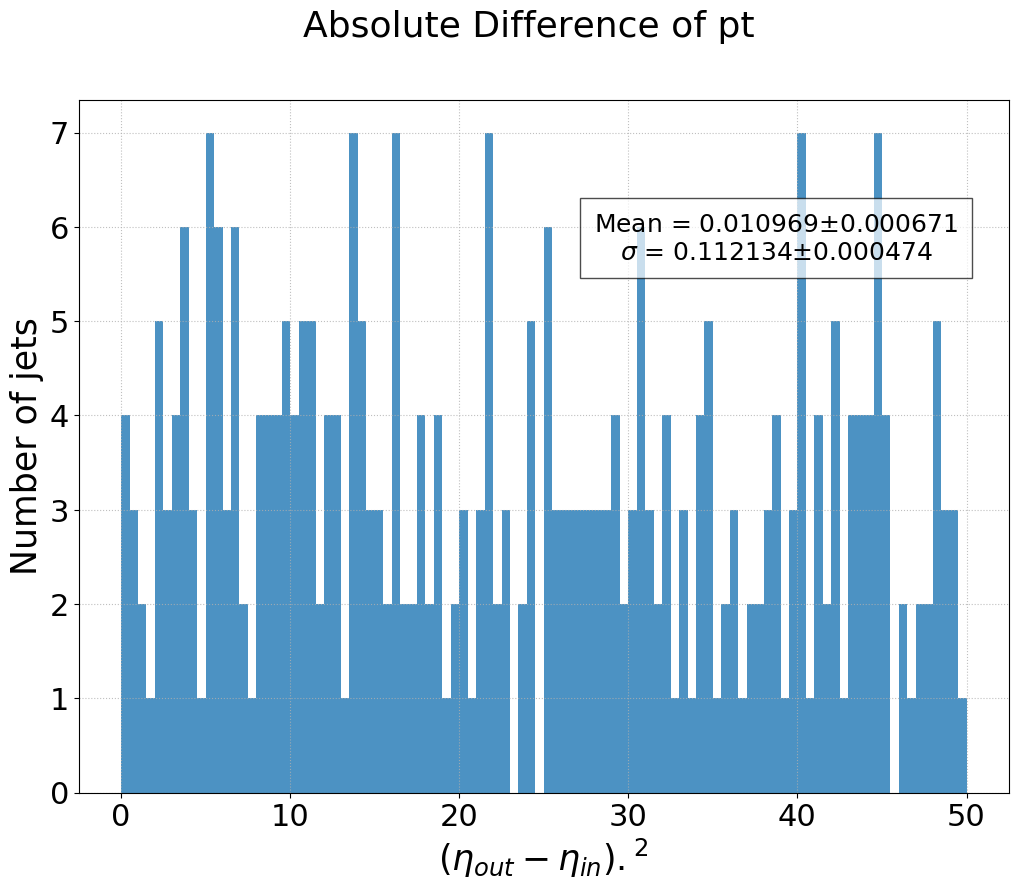

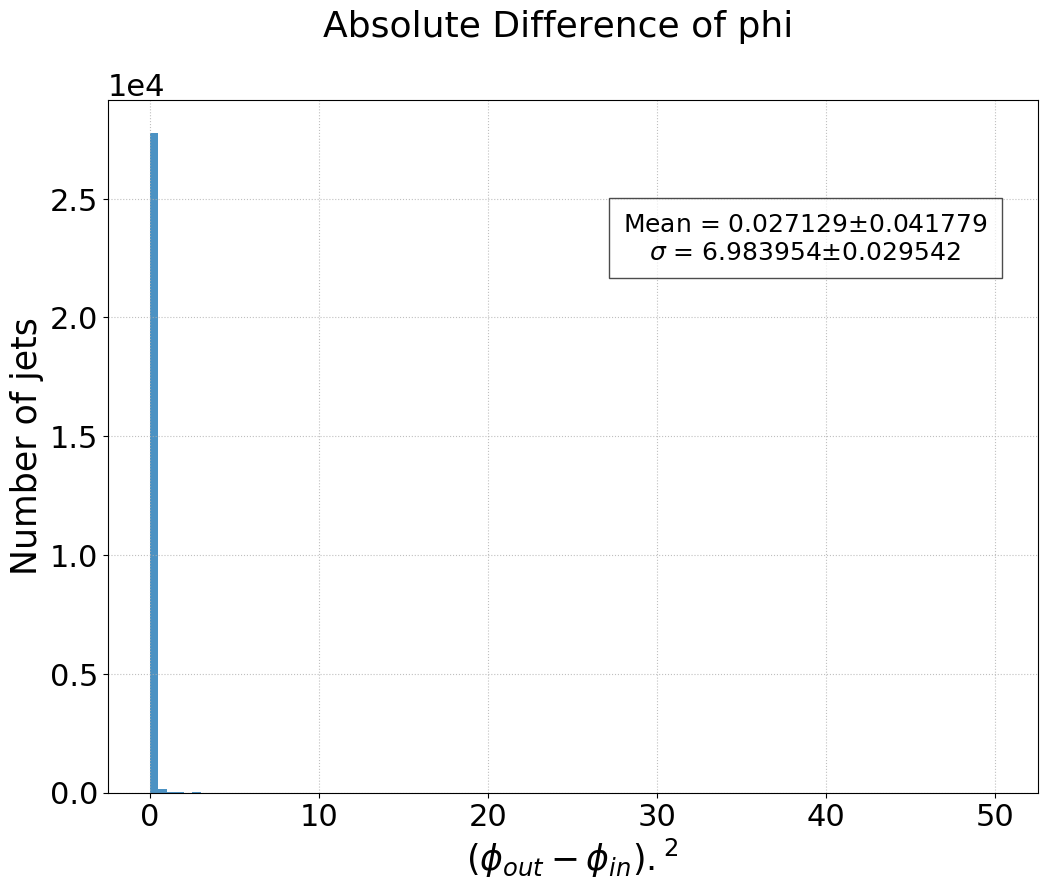

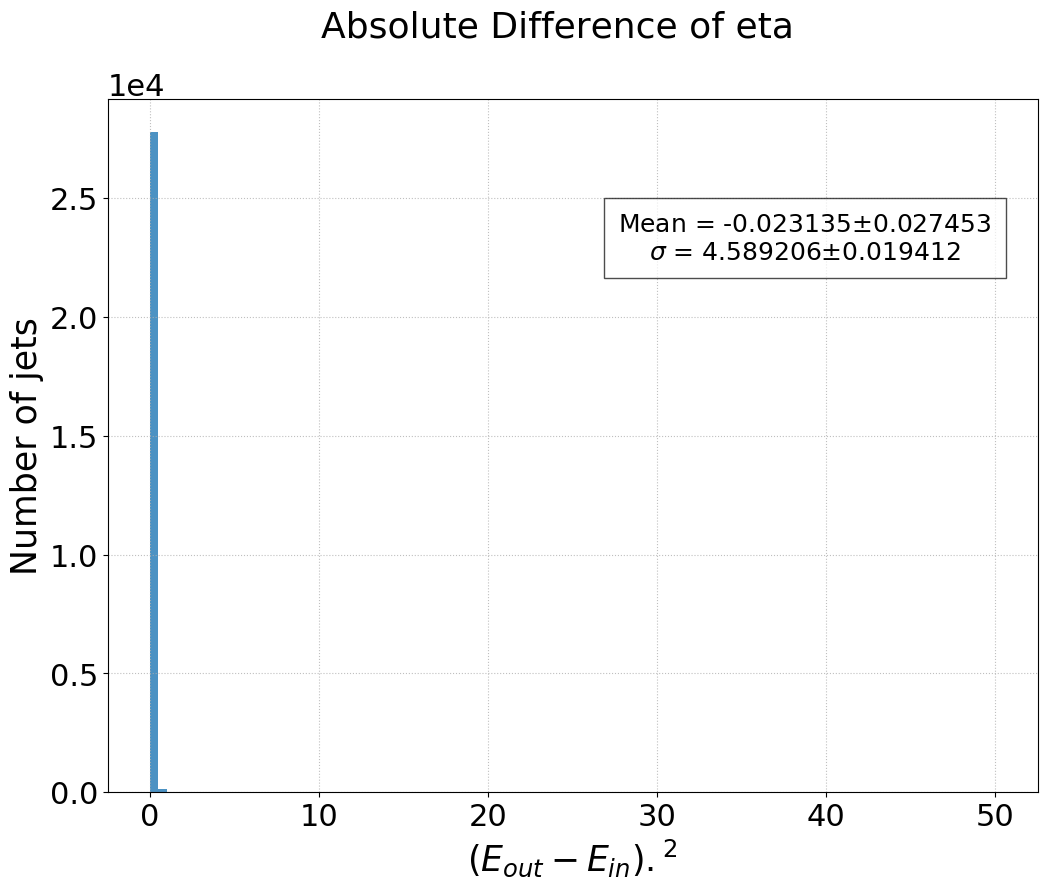

In [33]:
abs_strings = [r'|$(p_{T,out} - p_{T,in})|',
                        r'|$(\eta_{out} - \eta_{in})|',
                        r'|$(\phi_{out} - \phi_{in})|',
                        r'|$(E_{out} - E_{in})|']
absolute= abs(pred - data.detach().numpy())
#range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        absolute[:, kk], label='Absolute Difference', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Absolute Difference of %s' % train.columns[kk])
    plt.xlabel(mse_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_mse_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)



###Correlation

Correlation is a measure of similarity. Therefore correlation between input and output helps in analysing the difference between them.

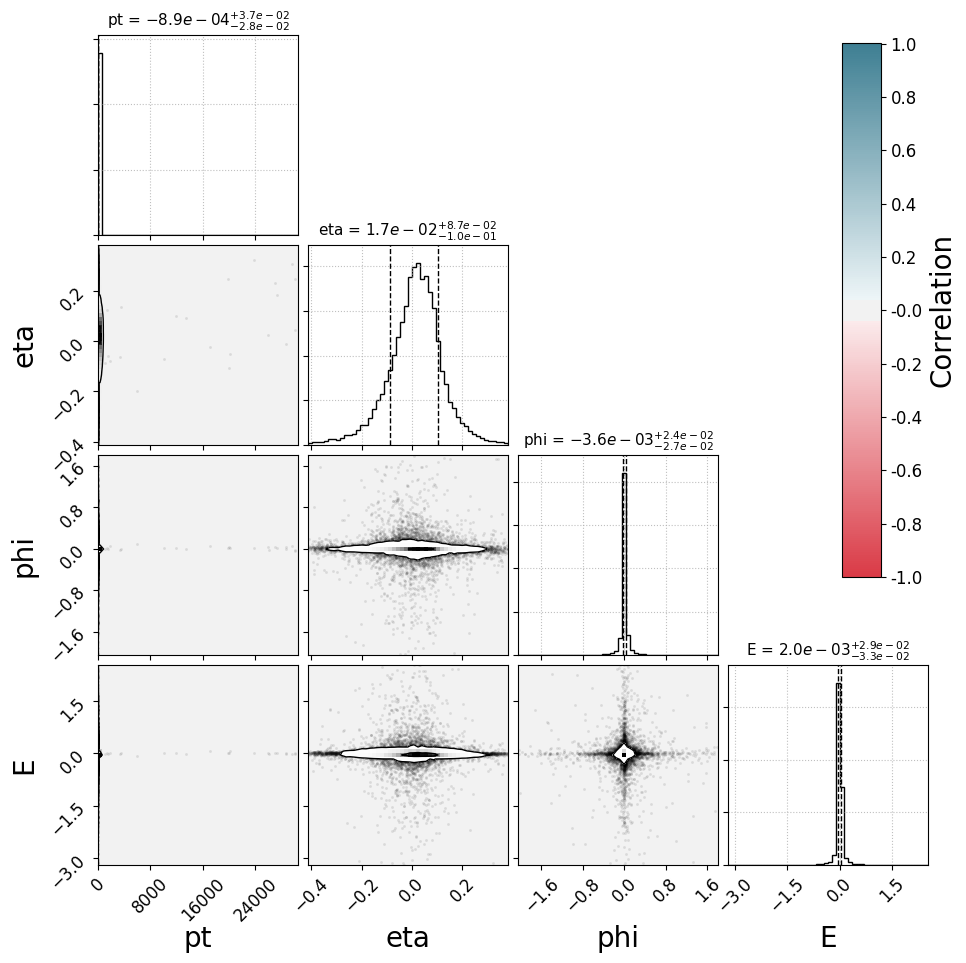

In [36]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)